In [91]:
import pandas as pd
import ast

df = pd.read_csv('../exports/export_2024-04-07.csv', header=None, names=['ID', 'Title', 'Date', 'Keywords'])

df.drop(df.index[0], inplace=True) # csv header row

def safe_literal_eval(s):
  try:
    return ast.literal_eval(s)
  except ValueError:
    return []
  except SyntaxError:
    return []

# converts the string representation of the list to a list
df['Keywords'] = df['Keywords'].apply(safe_literal_eval)

# convert the date to a datetime object for easier manipulation
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

all_dates_by_week = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='W')

In [126]:

# format the date ranges for visualization
date_ranges = list(zip(all_dates_by_week[:-1], all_dates_by_week[1:])) 
date_ranges_named = [f"{start.date()} - {end.date()}" for start, end in date_ranges]  

# create a dataframe to store the weekly article count
weekly_df = pd.DataFrame(date_ranges_named, columns=['Week'])
weekly_df[['Start', 'End']] = [(start, end) for start, end in date_ranges]

# sum up the articles for each week
for start, end in date_ranges:
  mask = (df['Date'] >= start) & (df['Date'] < end)
  weekly_df.loc[weekly_df['Start'] == start, 'Article count'] = mask.sum()

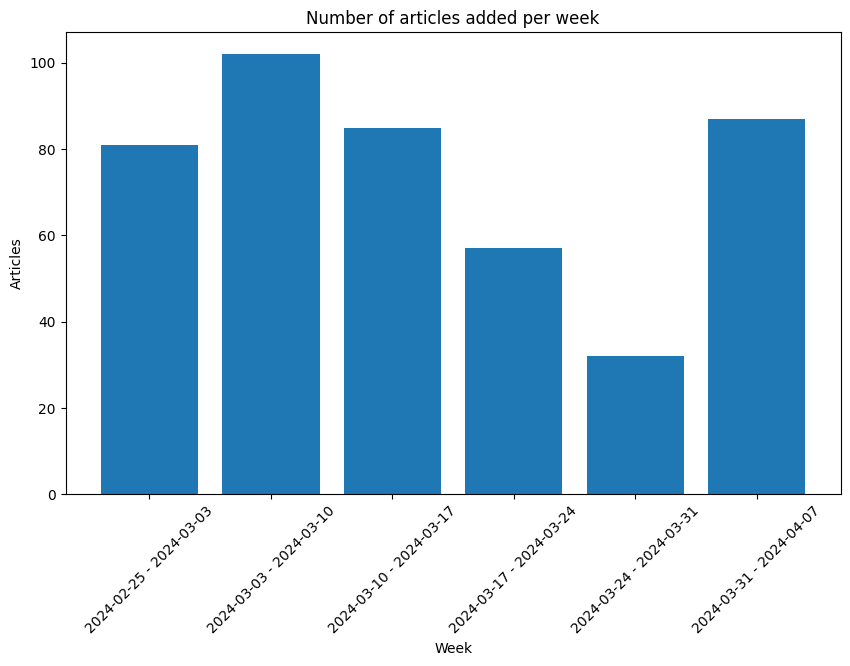

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(weekly_df['Week'], weekly_df['Article count'])
plt.xlabel('Week')
plt.ylabel('Articles')
plt.title('Number of articles added per week')
plt.xticks(rotation=45)
plt.show()


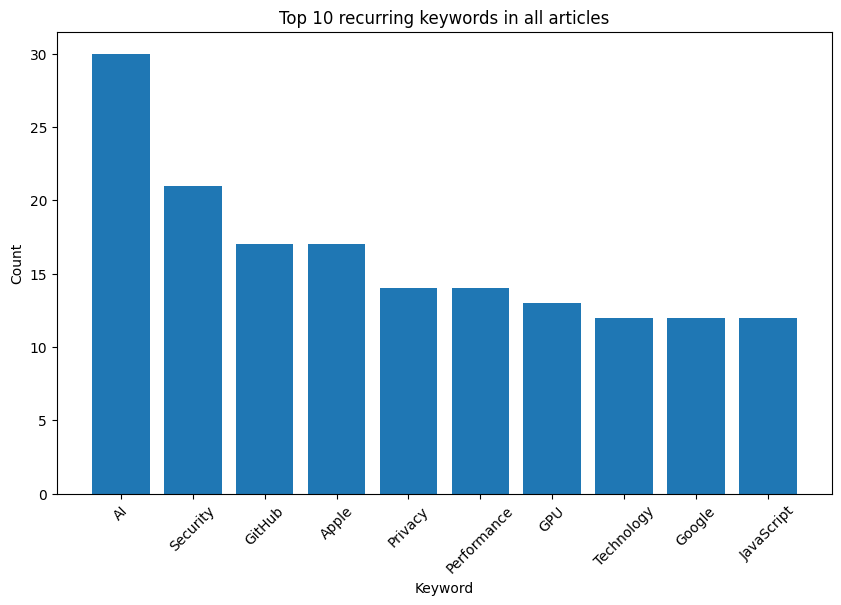

In [128]:
# get the top 10 keywords
from collections import Counter

all_keywords = [keyword for keywords in df['Keywords'] for keyword in keywords]
keyword_counts = Counter(all_keywords)

top_10_keywords = keyword_counts.most_common(10)

top_10_keywords_df = pd.DataFrame(top_10_keywords, columns=['Keyword', 'Count'])

plt.figure(figsize=(10, 6))
plt.bar(top_10_keywords_df['Keyword'], top_10_keywords_df['Count'])
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Top 10 recurring keywords in all articles')
plt.xticks(rotation=45)
plt.show()

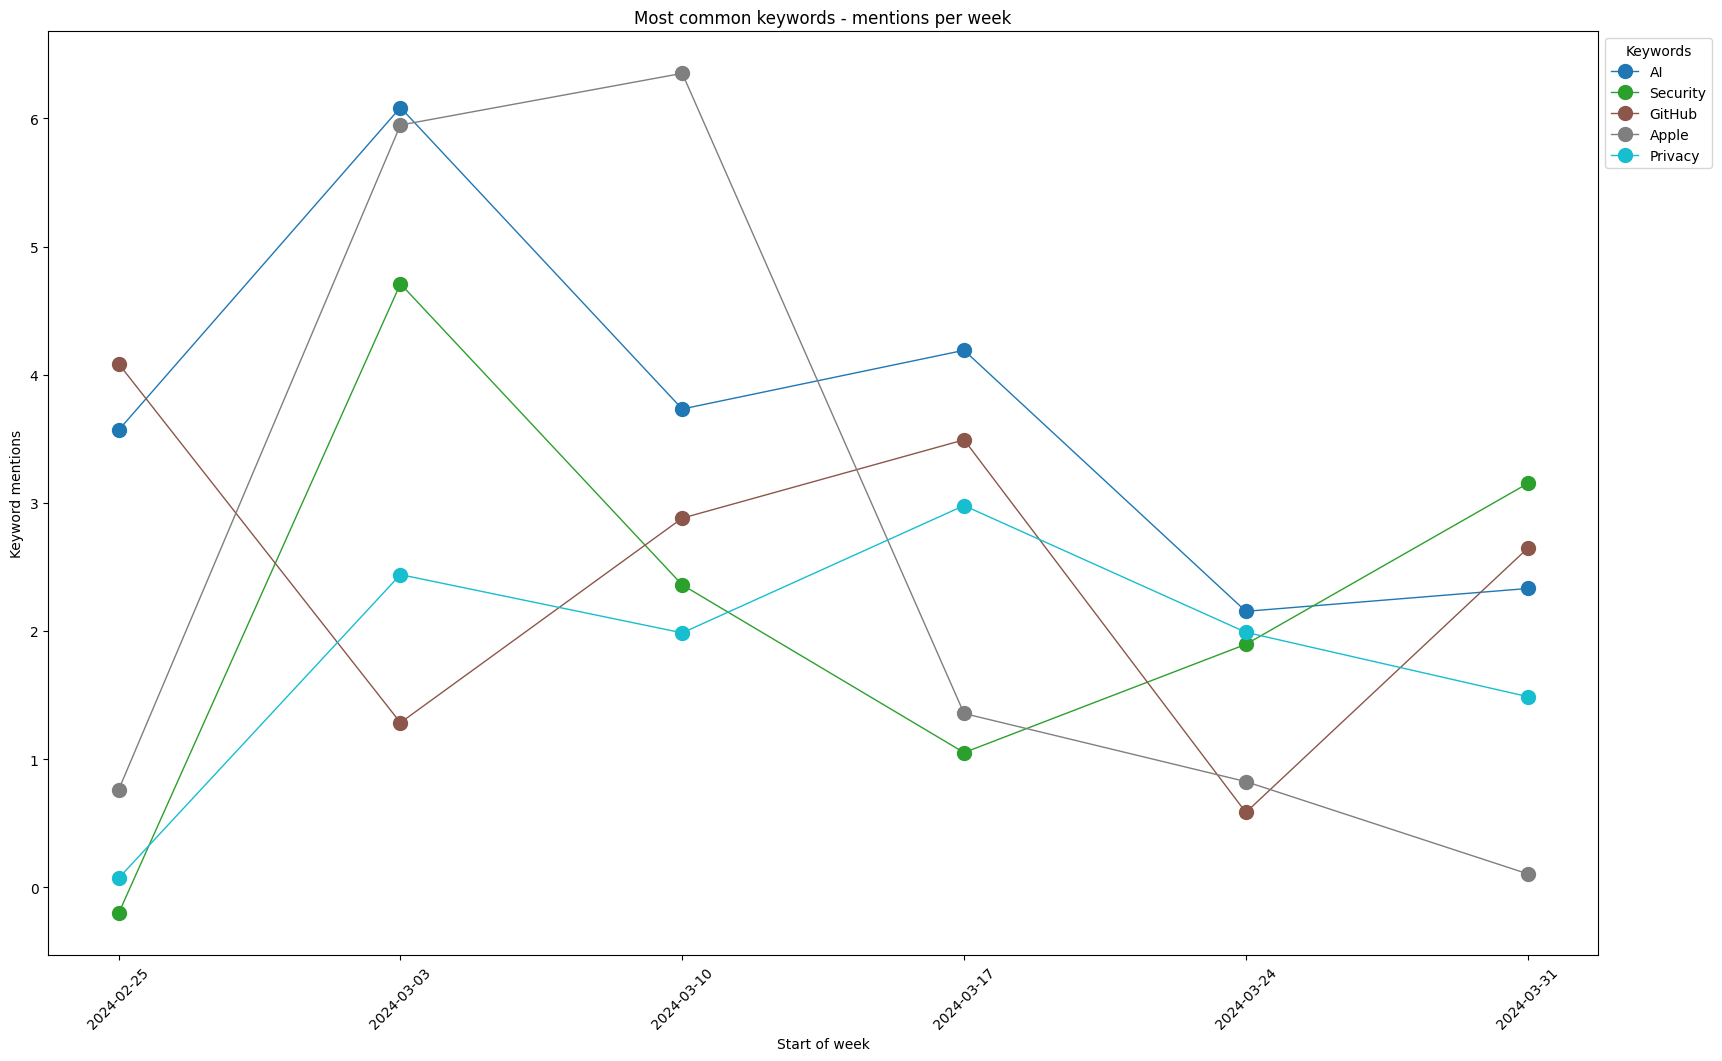

In [203]:
import numpy as np

TOP_KEYWORDS_AMOUNT = 5

top = [keyword for keyword, _ in keyword_counts.most_common(TOP_KEYWORDS_AMOUNT)]

weekly_keywords = []

for start, end in date_ranges:
  mask = (df['Date'] >= start) & (df['Date'] < end)
  weekly_keywords.append([keyword for keywords in df[mask]['Keywords'] for keyword in keywords])

weekly_keyword_counts = [Counter(keywords) for keywords in weekly_keywords]

# get the count of mentions for the top 5 keywords per week
top_weekly_keywords = []
for keyword_count in weekly_keyword_counts:
    week_top_keywords = [(keyword, count) for keyword, count in keyword_count.items() if keyword in top]
    top_weekly_keywords.append(week_top_keywords)

# initialize the dictionary with zeros
keywords_dict = {}
for keyword in top:
  keywords_dict[keyword] = [0] * len(weekly_keywords)  

# add the mentions per week to the respective keyword
for week in top_weekly_keywords:
  for keyword, count in week:
    index = top_weekly_keywords.index(week)
    keywords_dict[keyword][index] = count

list_counts_per_keyword = [counts for _ , counts in keywords_dict.items()]

# setting up the plot
fig, ax = plt.subplots(figsize=(20, 12))
weeks = np.arange(len(weekly_keywords))
colors = plt.cm.tab10(np.linspace(0, 1, len(keywords_dict)))

for counts, color, keyword in zip(list_counts_per_keyword, colors, top):
    jittered_counts = counts + np.random.normal(0, 0.3, size=len(counts))
    ax.plot(weeks, jittered_counts, color=color, label=keyword, linewidth=1, markersize=10, marker='o')

ax.set_xlabel('Start of week')
ax.set_ylabel('Keyword mentions')
ax.set_title('Most common keywords - mentions per week')
ax.set_xticks(weeks)
week_labels = [start.date() for start, end in date_ranges]
ax.set_xticklabels(week_labels, rotation=45)
ax.legend(title='Keywords', bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

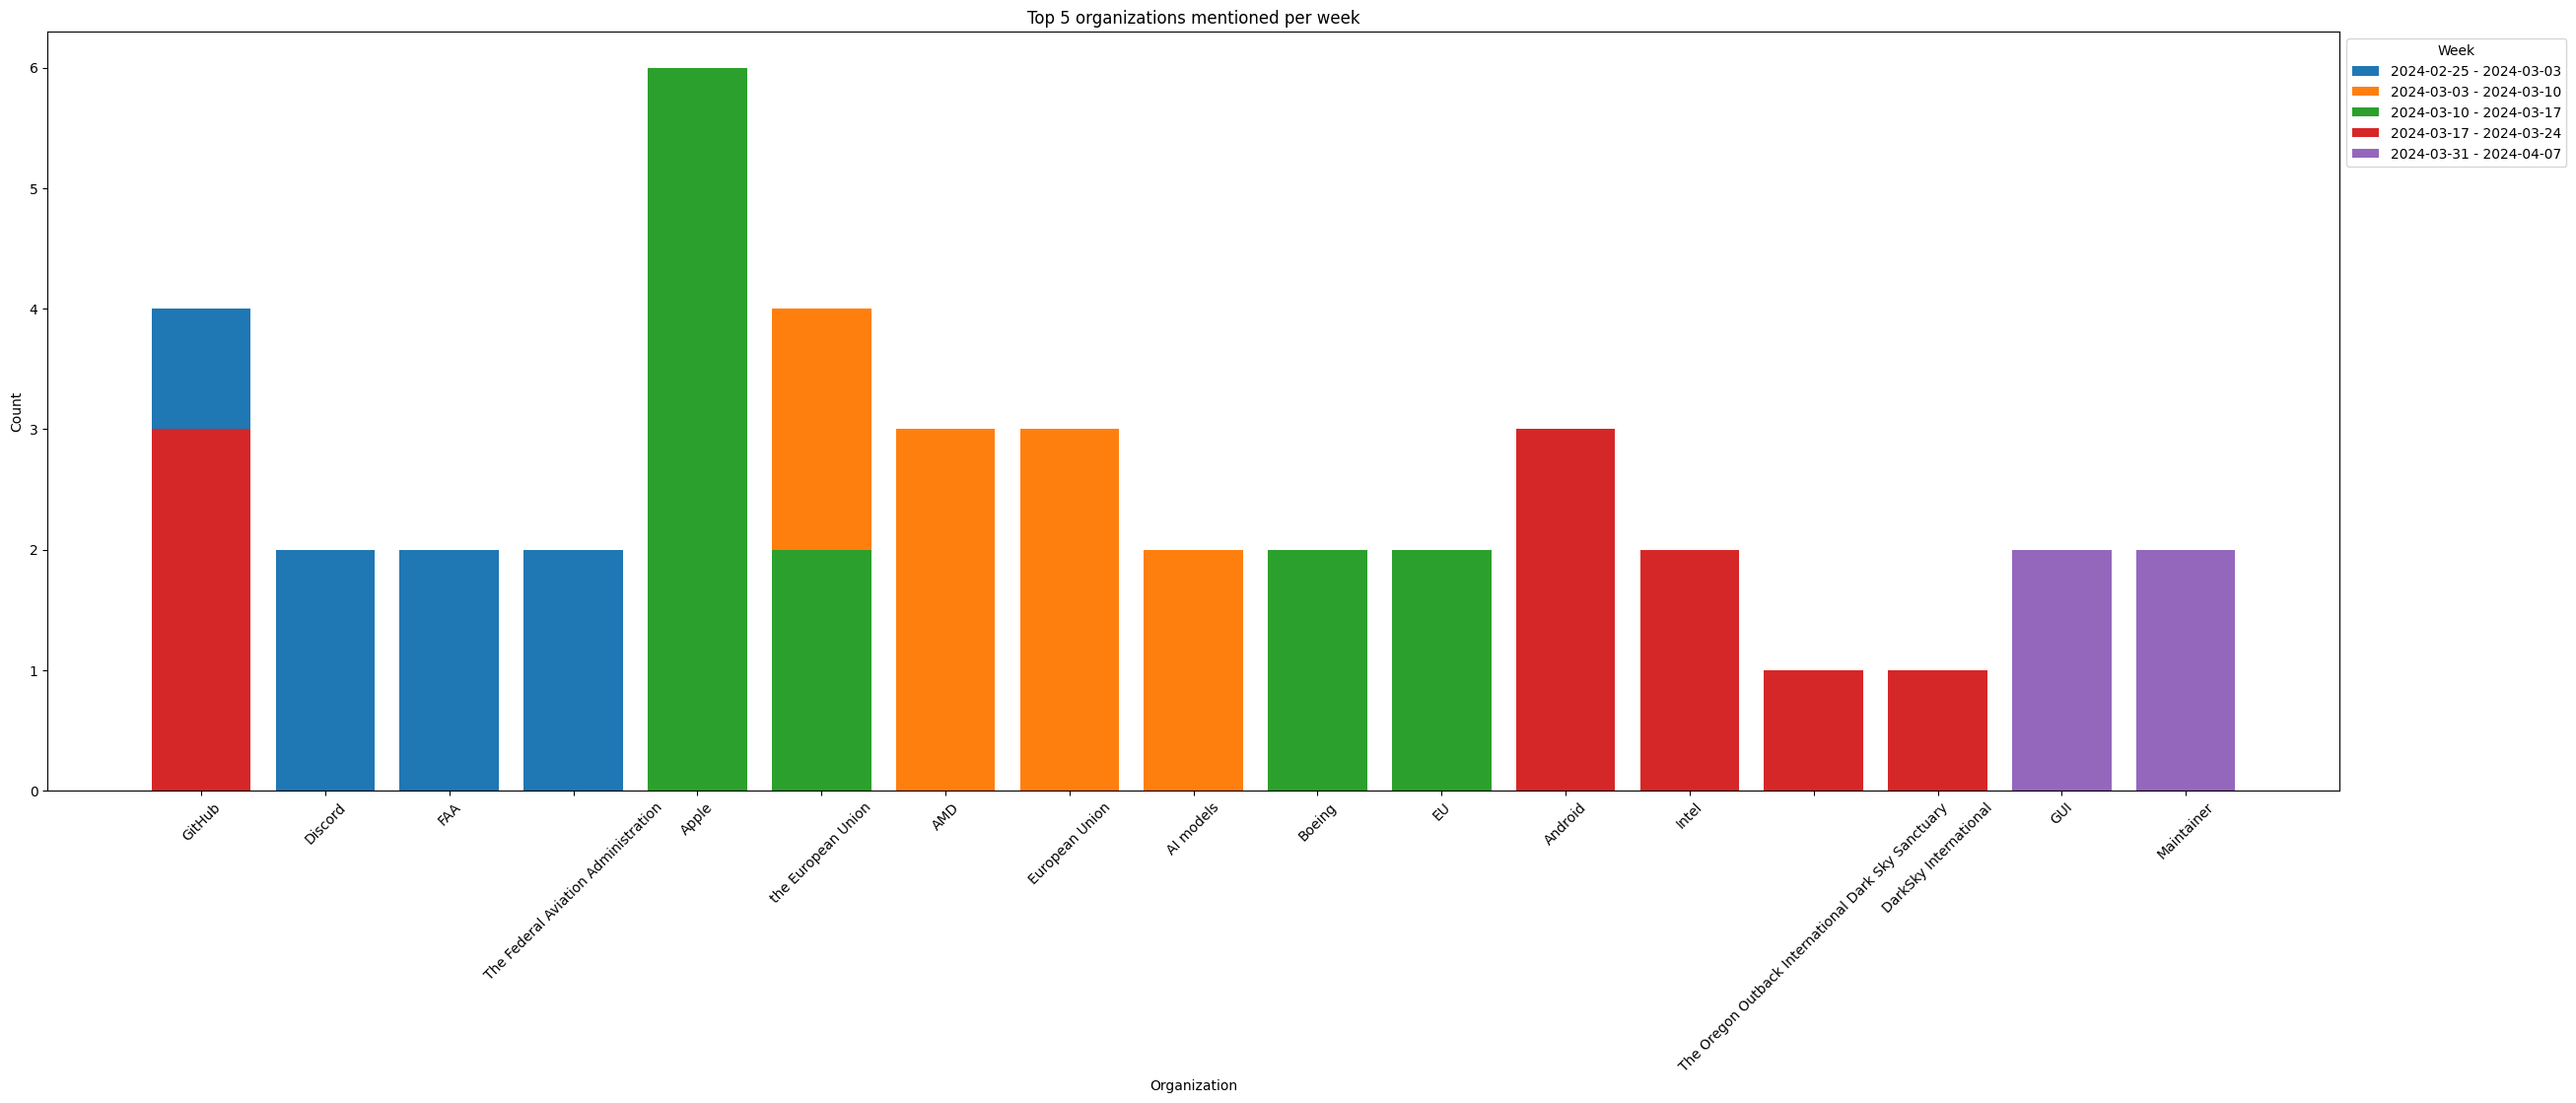

In [253]:
import spacy
nlp = spacy.load('en_core_web_sm')

EVAL_COUNT = 20

top_weekly = {}
# sort them by count
for i, keyword_count in enumerate(weekly_keyword_counts):
  top_weekly[i] = keyword_count.most_common(EVAL_COUNT)

# name the weeks
top_weekly = {date_ranges_named[i]: top_weekly[i] for i in range(len(date_ranges_named))}
top_weekly_df = pd.DataFrame(top_weekly).T

# get descriptive keywords
COMMON_ABBREVIATIONS = ['AI', 'ML', 'CSS', 'API', 'GPU', 'SQL']
def is_organization(keyword):
  if keyword in COMMON_ABBREVIATIONS:
    return False
  doc = nlp(keyword)
  for ent in doc.ents:
    if ent.label_ == 'ORG':
      return True
  return False

top_5_weekly_orgs = {}
for week, keywords in top_weekly.items():
  for keyword, count in keywords:
    if is_organization(keyword):
      if week not in top_5_weekly_orgs:
        top_5_weekly_orgs[week] = [(keyword, count)]
      else:
        top_5_weekly_orgs[week].append((keyword, count))


# show the top 5 org mentions, colored per week
plt.figure(figsize=(30, 10))
for week, keywords in top_5_weekly_orgs.items():
  x = [keyword for keyword, _ in keywords]
  y = [count for _, count in keywords]
  plt.bar(x, y, label=week)

plt.xlabel('Organization')
plt.ylabel('Count')
plt.title('Top 5 organizations mentioned per week')
plt.xticks(rotation=45)
plt.legend(title='Week', bbox_to_anchor=(1, 1), loc='upper left')

plt.autoscale()
plt.show()